In [21]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import itertools
import math
import os , shutil

In [2]:
DIR = "../Dataset"

In [3]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(DIR, validation_split=0.1, subset="training", seed=42, batch_size=32, image_size=(256, 256))

Found 8984 files belonging to 5 classes.
Using 8086 files for training.


In [4]:
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(DIR, validation_split=0.1, subset="validation", seed=42, batch_size=32, image_size=(256, 256))

Found 8984 files belonging to 5 classes.
Using 898 files for validation.


In [5]:
classes = train_dataset.class_names
numClasses = len(train_dataset.class_names)
print(classes)

['Bacterial Pneumonia', 'COVID', 'Normal', 'Tuberculosis', 'Viral Pneumonia']


In [6]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [7]:
baseModel = tf.keras.applications.MobileNetV3Large(input_shape=(256, 256,3), weights='imagenet', include_top=False, classes=numClasses)

In [8]:
last_output = baseModel.layers[-1].output
x = tf.keras.layers.Dropout(0.5) (last_output)
x = tf.keras.layers.GlobalMaxPooling2D() (last_output)
x = tf.keras.layers.Dense(256, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.02), activity_regularizer=tf.keras.regularizers.l2(0.02),  kernel_initializer='he_normal')(x)
x = tf.keras.layers.BatchNormalization() (x)
x = tf.keras.layers.Dropout(0.45) (x)
x = tf.keras.layers.Dense(numClasses, activation='softmax')(x)

In [9]:
model = tf.keras.Model(inputs=baseModel.input, outputs=x)

In [10]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [11]:
epochs = 40
stepDecay = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.1 * 0.1**math.floor(epoch / 6))

In [12]:
history = model.fit(train_dataset, validation_data=test_dataset, epochs=epochs, callbacks=[stepDecay])

Epoch 1/40
253/253 [==============================] - 927s 4s/step - loss: 149.8443 - accuracy: 0.3394 - val_loss: 46.9193 - val_accuracy: 0.3508 - lr: 0.1000
Epoch 2/40
253/253 [==============================] - 888s 3s/step - loss: 21.0515 - accuracy: 0.3432 - val_loss: 7.4940 - val_accuracy: 0.3508 - lr: 0.1000
Epoch 3/40
253/253 [==============================] - 890s 3s/step - loss: 4.3748 - accuracy: 0.3432 - val_loss: 2.4184 - val_accuracy: 0.3508 - lr: 0.1000
Epoch 4/40
253/253 [==============================] - 998s 4s/step - loss: 1.9040 - accuracy: 0.3432 - val_loss: 1.6366 - val_accuracy: 0.3508 - lr: 0.1000
Epoch 5/40
253/253 [==============================] - 1001s 4s/step - loss: 455.0684 - accuracy: 0.3432 - val_loss: 275.7650 - val_accuracy: 0.3508 - lr: 0.1000
Epoch 6/40
253/253 [==============================] - 915s 4s/step - loss: 119.5198 - accuracy: 0.3432 - val_loss: 37.6070 - val_accuracy: 0.3508 - lr: 0.1000
Epoch 7/40
253/253 [==============================] 

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 128, 128, 16  432         ['rescaling[0][0]']              
                                )                                                                 
                                                                                              

                                                                                                  
 expanded_conv_2/depthwise/Batc  (None, 64, 64, 72)  288         ['expanded_conv_2/depthwise[0][0]
 hNorm (BatchNormalization)                                      ']                               
                                                                                                  
 re_lu_5 (ReLU)                 (None, 64, 64, 72)   0           ['expanded_conv_2/depthwise/Batch
                                                                 Norm[0][0]']                     
                                                                                                  
 expanded_conv_2/project (Conv2  (None, 64, 64, 24)  1728        ['re_lu_5[0][0]']                
 D)                                                                                               
                                                                                                  
 expanded_

                                                                                                  
 re_lu_10 (ReLU)                (None, 32, 32, 120)  0           ['expanded_conv_4/depthwise/Batch
                                                                 Norm[0][0]']                     
                                                                                                  
 expanded_conv_4/squeeze_excite  (None, 1, 1, 120)   0           ['re_lu_10[0][0]']               
 /AvgPool (GlobalAveragePooling                                                                   
 2D)                                                                                              
                                                                                                  
 expanded_conv_4/squeeze_excite  (None, 1, 1, 32)    3872        ['expanded_conv_4/squeeze_excite/
 /Conv (Conv2D)                                                  AvgPool[0][0]']                  
          

                                                                                                  
 expanded_conv_5/project/BatchN  (None, 32, 32, 40)  160         ['expanded_conv_5/project[0][0]']
 orm (BatchNormalization)                                                                         
                                                                                                  
 expanded_conv_5/Add (Add)      (None, 32, 32, 40)   0           ['expanded_conv_4/Add[0][0]',    
                                                                  'expanded_conv_5/project/BatchNo
                                                                 rm[0][0]']                       
                                                                                                  
 expanded_conv_6/expand (Conv2D  (None, 32, 32, 240)  9600       ['expanded_conv_5/Add[0][0]']    
 )                                                                                                
          

 )                                                                                                
                                                                                                  
 multiply_4 (Multiply)          (None, 16, 16, 200)  0           ['expanded_conv_7/depthwise/Batch
                                                                 Norm[0][0]',                     
                                                                  'tf.math.multiply_7[0][0]']     
                                                                                                  
 expanded_conv_7/project (Conv2  (None, 16, 16, 80)  16000       ['multiply_4[0][0]']             
 D)                                                                                               
                                                                                                  
 expanded_conv_7/project/BatchN  (None, 16, 16, 80)  320         ['expanded_conv_7/project[0][0]']
 orm (Batc

                                                                                                  
 expanded_conv_9/depthwise/Batc  (None, 16, 16, 184)  736        ['expanded_conv_9/depthwise[0][0]
 hNorm (BatchNormalization)                                      ']                               
                                                                                                  
 tf.__operators__.add_11 (TFOpL  (None, 16, 16, 184)  0          ['expanded_conv_9/depthwise/Batch
 ambda)                                                          Norm[0][0]']                     
                                                                                                  
 re_lu_22 (ReLU)                (None, 16, 16, 184)  0           ['tf.__operators__.add_11[0][0]']
                                                                                                  
 tf.math.multiply_11 (TFOpLambd  (None, 16, 16, 184)  0          ['re_lu_22[0][0]']               
 a)       

 expanded_conv_10/squeeze_excit  (None, 16, 16, 480)  0          ['multiply_10[0][0]',            
 e/Mul (Multiply)                                                 'tf.math.multiply_14[0][0]']    
                                                                                                  
 expanded_conv_10/project (Conv  (None, 16, 16, 112)  53760      ['expanded_conv_10/squeeze_excite
 2D)                                                             /Mul[0][0]']                     
                                                                                                  
 expanded_conv_10/project/Batch  (None, 16, 16, 112)  448        ['expanded_conv_10/project[0][0]'
 Norm (BatchNormalization)                                       ]                                
                                                                                                  
 expanded_conv_11/expand (Conv2  (None, 16, 16, 672)  75264      ['expanded_conv_10/project/BatchN
 D)       

 expanded_conv_12/expand/BatchN  (None, 16, 16, 672)  2688       ['expanded_conv_12/expand[0][0]']
 orm (BatchNormalization)                                                                         
                                                                                                  
 tf.__operators__.add_18 (TFOpL  (None, 16, 16, 672)  0          ['expanded_conv_12/expand/BatchNo
 ambda)                                                          rm[0][0]']                       
                                                                                                  
 re_lu_29 (ReLU)                (None, 16, 16, 672)  0           ['tf.__operators__.add_18[0][0]']
                                                                                                  
 tf.math.multiply_18 (TFOpLambd  (None, 16, 16, 672)  0          ['re_lu_29[0][0]']               
 a)                                                                                               
          

                                                                                                  
 expanded_conv_13/depthwise (De  (None, 8, 8, 960)   24000       ['multiply_15[0][0]']            
 pthwiseConv2D)                                                                                   
                                                                                                  
 expanded_conv_13/depthwise/Bat  (None, 8, 8, 960)   3840        ['expanded_conv_13/depthwise[0][0
 chNorm (BatchNormalization)                                     ]']                              
                                                                                                  
 tf.__operators__.add_22 (TFOpL  (None, 8, 8, 960)   0           ['expanded_conv_13/depthwise/Batc
 ambda)                                                          hNorm[0][0]']                    
                                                                                                  
 re_lu_33 

 tf.math.multiply_25 (TFOpLambd  (None, 8, 8, 960)   0           ['re_lu_36[0][0]']               
 a)                                                                                               
                                                                                                  
 multiply_18 (Multiply)         (None, 8, 8, 960)    0           ['expanded_conv_14/depthwise/Batc
                                                                 hNorm[0][0]',                    
                                                                  'tf.math.multiply_25[0][0]']    
                                                                                                  
 expanded_conv_14/squeeze_excit  (None, 1, 1, 960)   0           ['multiply_18[0][0]']            
 e/AvgPool (GlobalAveragePoolin                                                                   
 g2D)                                                                                             
          

In [5]:
plt.plot(range(0, epochs), history.history["loss"], color="b", label="Loss")
plt.plot(range(0, epochs), history.history["val_loss"], color="r", label="Test Loss")
plt.legend()
plt.show()

ModuleNotFoundError: No module named 'pyplot'

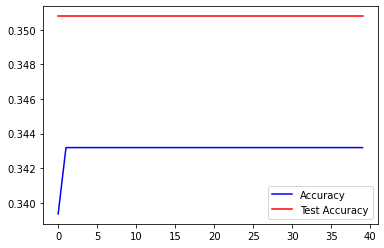

In [19]:
plt.plot(range(0, epochs), history.history["accuracy"], color="b", label="Accuracy")
plt.plot(range(0, epochs), history.history["val_accuracy"], color="r", label="Test Accuracy")
plt.legend()
plt.show()

In [27]:
model = tf.keras.models.load_model("XrayClassificationModel.h5")

In [28]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 128, 128, 16  432         ['rescaling[0][0]']              
                                )                                                                 
                                                                                              

 expanded_conv_1/depthwise/Batc  (None, 32, 32, 72)  288         ['expanded_conv_1/depthwise[0][0]
 hNorm (BatchNormalization)                                      ']                               
                                                                                                  
 re_lu_4 (ReLU)                 (None, 32, 32, 72)   0           ['expanded_conv_1/depthwise/Batch
                                                                 Norm[0][0]']                     
                                                                                                  
 expanded_conv_1/project (Conv2  (None, 32, 32, 24)  1728        ['re_lu_4[0][0]']                
 D)                                                                                               
                                                                                                  
 expanded_conv_1/project/BatchN  (None, 32, 32, 24)  96          ['expanded_conv_1/project[0][0]']
 orm (Batc

                                                                                                  
 expanded_conv_3/squeeze_excite  (None, 1, 1, 24)    2328        ['expanded_conv_3/squeeze_excite/
 /Conv (Conv2D)                                                  AvgPool[0][0]']                  
                                                                                                  
 expanded_conv_3/squeeze_excite  (None, 1, 1, 24)    0           ['expanded_conv_3/squeeze_excite/
 /Relu (ReLU)                                                    Conv[0][0]']                     
                                                                                                  
 expanded_conv_3/squeeze_excite  (None, 1, 1, 96)    2400        ['expanded_conv_3/squeeze_excite/
 /Conv_1 (Conv2D)                                                Relu[0][0]']                     
                                                                                                  
 tf.__oper

                                                                                                  
 expanded_conv_4/squeeze_excite  (None, 16, 16, 240)  0          ['multiply_4[0][0]',             
 /Mul (Multiply)                                                  'tf.math.multiply_7[0][0]']     
                                                                                                  
 expanded_conv_4/project (Conv2  (None, 16, 16, 40)  9600        ['expanded_conv_4/squeeze_excite/
 D)                                                              Mul[0][0]']                      
                                                                                                  
 expanded_conv_4/project/BatchN  (None, 16, 16, 40)  160         ['expanded_conv_4/project[0][0]']
 orm (BatchNormalization)                                                                         
                                                                                                  
 expanded_

                                                                 rm[0][0]']                       
                                                                                                  
 expanded_conv_6/expand (Conv2D  (None, 16, 16, 120)  4800       ['expanded_conv_5/Add[0][0]']    
 )                                                                                                
                                                                                                  
 expanded_conv_6/expand/BatchNo  (None, 16, 16, 120)  480        ['expanded_conv_6/expand[0][0]'] 
 rm (BatchNormalization)                                                                          
                                                                                                  
 tf.__operators__.add_11 (TFOpL  (None, 16, 16, 120)  0          ['expanded_conv_6/expand/BatchNor
 ambda)                                                          m[0][0]']                        
          

                                                                 m[0][0]',                        
                                                                  'tf.math.multiply_14[0][0]']    
                                                                                                  
 expanded_conv_7/depthwise (Dep  (None, 16, 16, 144)  3600       ['multiply_9[0][0]']             
 thwiseConv2D)                                                                                    
                                                                                                  
 expanded_conv_7/depthwise/Batc  (None, 16, 16, 144)  576        ['expanded_conv_7/depthwise[0][0]
 hNorm (BatchNormalization)                                      ']                               
                                                                                                  
 tf.__operators__.add_15 (TFOpL  (None, 16, 16, 144)  0          ['expanded_conv_7/depthwise/Batch
 ambda)   

 tf.__operators__.add_18 (TFOpL  (None, 8, 8, 288)   0           ['expanded_conv_8/depthwise/Batch
 ambda)                                                          Norm[0][0]']                     
                                                                                                  
 re_lu_23 (ReLU)                (None, 8, 8, 288)    0           ['tf.__operators__.add_18[0][0]']
                                                                                                  
 tf.math.multiply_18 (TFOpLambd  (None, 8, 8, 288)   0           ['re_lu_23[0][0]']               
 a)                                                                                               
                                                                                                  
 multiply_12 (Multiply)         (None, 8, 8, 288)    0           ['expanded_conv_8/depthwise/Batch
                                                                 Norm[0][0]',                     
          

 /Conv (Conv2D)                                                  AvgPool[0][0]']                  
                                                                                                  
 expanded_conv_9/squeeze_excite  (None, 1, 1, 144)   0           ['expanded_conv_9/squeeze_excite/
 /Relu (ReLU)                                                    Conv[0][0]']                     
                                                                                                  
 expanded_conv_9/squeeze_excite  (None, 1, 1, 576)   83520       ['expanded_conv_9/squeeze_excite/
 /Conv_1 (Conv2D)                                                Relu[0][0]']                     
                                                                                                  
 tf.__operators__.add_22 (TFOpL  (None, 1, 1, 576)   0           ['expanded_conv_9/squeeze_excite/
 ambda)                                                          Conv_1[0][0]']                   
          

                                                                                                  
 tf.math.multiply_25 (TFOpLambd  (None, 1, 1, 576)   0           ['re_lu_30[0][0]']               
 a)                                                                                               
                                                                                                  
 expanded_conv_10/squeeze_excit  (None, 8, 8, 576)   0           ['multiply_16[0][0]',            
 e/Mul (Multiply)                                                 'tf.math.multiply_25[0][0]']    
                                                                                                  
 expanded_conv_10/project (Conv  (None, 8, 8, 96)    55296       ['expanded_conv_10/squeeze_excite
 2D)                                                             /Mul[0][0]']                     
                                                                                                  
 expanded_

In [29]:
model.save("model.h5")

[3.2144620e+00 9.8284617e-02 3.1025929e-02 7.8127295e-04 9.6655441e+01] 
 ['Bacterial Pneumonia', 'COVID', 'Normal', 'Tuberculosis', 'Viral Pneumonia']
Prediction:  Viral Pneumonia 96.65544033050537%


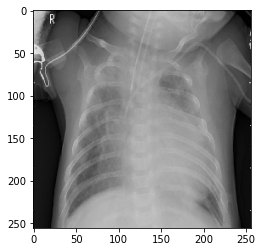

In [33]:
import requests

img_data = requests.get("https://cdn0.scrvt.com/0e46935d037de4ec3888566275864b37/1800000007267893/5a55409c371b/v/f8eac2053bc7/x-ray-COVID-19-2_1800000007267893.jpg?nowebp=1").content
with open('img.jpg', 'wb') as handler:
    handler.write(img_data)

path = "person1_virus_6.jpeg"
#path = "/content/Covid19_Dataset/Normal/Normal-1000.png"

img = tf.keras.preprocessing.image.load_img(path, target_size=(256, 256))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) 

predictions = model.predict(img_array)

plt.imshow(img)
print(predictions[0]*100, "\n", classes)
print("Prediction: ", classes[np.argmax(predictions)], f"{predictions[0][np.argmax(predictions)]*100}%")

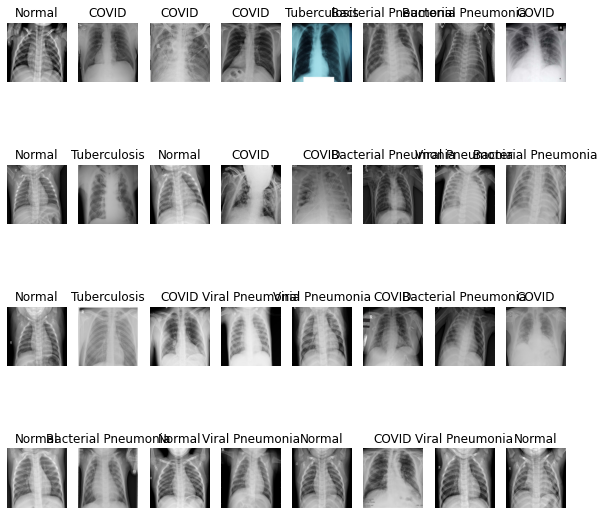

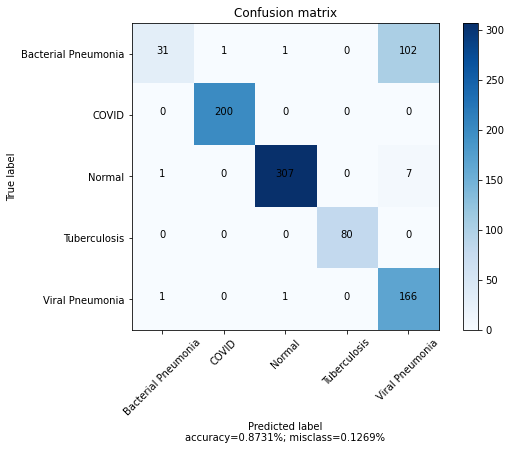

In [34]:
def plot_confusion_matrix(cm, target_names, cmap=None):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix')
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}%; misclass={:0.4f}%'.format(accuracy, misclass))
    plt.show()

plt.figure(figsize=(10, 10))
true = []
predictions = []

for images, labels in test_dataset.take(1900):
  pred = model.predict(images)
  for i in range(32):
    try:
      ax = plt.subplot(4, 8, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      #print(classes[np.argmax(pred[i])], 100 * np.max(pred[i]), "real = " + str(classes[labels[i]]))

      true.append(labels[i])
      predictions.append(np.argmax(pred[i]))

      plt.title(classes[labels[i]])
      plt.axis("off")
    except:
      print()

"""path = "Covid19_Dataset"
for i in os.listdir(path):
  folderPath = os.path.join(path, i)
  for j in os.listdir(folderPath)[:1500]:
    fullPath = os.path.join(folderPath, j)
    try:
      img = tf.keras.preprocessing.image.load_img(fullPath, target_size=(256, 256))
      img_array = tf.keras.preprocessing.image.img_to_array(img)
      img_array = tf.expand_dims(img_array, 0) 

      preds = model.predict(img_array)
      true.append(classes.index(i))
      predictions.append(np.argmax(preds))
      #print(fullPath)
    except:
      print("Error on image:", fullPath)"""

plot_confusion_matrix(tf.math.confusion_matrix(true, predictions), classes)

In [35]:
path = "Covid19_Dataset"
for i in os.listdir(path):
  folderPath = os.path.join(path, i)
  for j in os.listdir(folderPath)[:]:
    fullPath = os.path.join(folderPath, j)
    print(i, classes.index(i))

Bacterial Pneumonia 0
Bacterial Pneumonia 0
Bacterial Pneumonia 0
Bacterial Pneumonia 0
Bacterial Pneumonia 0
Bacterial Pneumonia 0
Bacterial Pneumonia 0
Bacterial Pneumonia 0
Bacterial Pneumonia 0
Bacterial Pneumonia 0
Bacterial Pneumonia 0
Bacterial Pneumonia 0
Bacterial Pneumonia 0
Bacterial Pneumonia 0
Bacterial Pneumonia 0
Bacterial Pneumonia 0
Bacterial Pneumonia 0
Bacterial Pneumonia 0
Bacterial Pneumonia 0
Bacterial Pneumonia 0
Bacterial Pneumonia 0
Bacterial Pneumonia 0
Bacterial Pneumonia 0
Bacterial Pneumonia 0
Bacterial Pneumonia 0
Bacterial Pneumonia 0
Bacterial Pneumonia 0
Bacterial Pneumonia 0
Bacterial Pneumonia 0
Bacterial Pneumonia 0
Bacterial Pneumonia 0
Bacterial Pneumonia 0
Bacterial Pneumonia 0
Bacterial Pneumonia 0
Bacterial Pneumonia 0
Bacterial Pneumonia 0
Bacterial Pneumonia 0
Bacterial Pneumonia 0
Bacterial Pneumonia 0
Bacterial Pneumonia 0
Bacterial Pneumonia 0
Bacterial Pneumonia 0
Bacterial Pneumonia 0
Bacterial Pneumonia 0
Bacterial Pneumonia 0
Bacterial 

Bacterial Pneumonia 0
Bacterial Pneumonia 0
Bacterial Pneumonia 0
Bacterial Pneumonia 0
Bacterial Pneumonia 0
Bacterial Pneumonia 0
Bacterial Pneumonia 0
Bacterial Pneumonia 0
Bacterial Pneumonia 0
Bacterial Pneumonia 0
Bacterial Pneumonia 0
Bacterial Pneumonia 0
Bacterial Pneumonia 0
Bacterial Pneumonia 0
Bacterial Pneumonia 0
Bacterial Pneumonia 0
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1


COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1
COVID 1


Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
N

Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
Normal 2
N

Tuberculosis 3
Tuberculosis 3
Tuberculosis 3
Tuberculosis 3
Tuberculosis 3
Tuberculosis 3
Tuberculosis 3
Tuberculosis 3
Tuberculosis 3
Tuberculosis 3
Tuberculosis 3
Tuberculosis 3
Tuberculosis 3
Tuberculosis 3
Tuberculosis 3
Tuberculosis 3
Tuberculosis 3
Tuberculosis 3
Tuberculosis 3
Tuberculosis 3
Tuberculosis 3
Tuberculosis 3
Tuberculosis 3
Tuberculosis 3
Tuberculosis 3
Tuberculosis 3
Tuberculosis 3
Tuberculosis 3
Tuberculosis 3
Tuberculosis 3
Tuberculosis 3
Tuberculosis 3
Tuberculosis 3
Tuberculosis 3
Tuberculosis 3
Tuberculosis 3
Tuberculosis 3
Tuberculosis 3
Tuberculosis 3
Tuberculosis 3
Tuberculosis 3
Tuberculosis 3
Tuberculosis 3
Tuberculosis 3
Tuberculosis 3
Tuberculosis 3
Tuberculosis 3
Tuberculosis 3
Tuberculosis 3
Tuberculosis 3
Tuberculosis 3
Tuberculosis 3
Tuberculosis 3
Tuberculosis 3
Tuberculosis 3
Tuberculosis 3
Tuberculosis 3
Tuberculosis 3
Tuberculosis 3
Tuberculosis 3
Tuberculosis 3
Tuberculosis 3
Tuberculosis 3
Tuberculosis 3
Tuberculosis 3
Tuberculosis 3
Tuberculos

Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneu

Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneumonia 4
Viral Pneu

In [ ]:
img_path='person1_virus_6.jpeg' 

successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(256, 256))
# Convert ht image to Array of dimension (150,150,3)
x   = tf.keras.preprocessing.image.img_to_array(img)                           
x   = x.reshape((1,) + x.shape)# Rescale by 1/255
x /= 255.0

successive_feature_maps = visualization_model.predict(x)
layer_names = [layer.name for layer in model.layers]

for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  print(feature_map.shape)
  if len(feature_map.shape) == 4:       
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    display_grid = np.zeros((size, size * n_features))
    
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x# Display the grid
    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='winter' )

In [ ]:
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import cv2
import imutils

class GradCAM:
  def __init__(self, model, classIdx, layerName=None):
    self.model = model
    self.classIdx = classIdx
    self.layerName = layerName
    if self.layerName is None:
      self.layerName = self.find_target_layer()
   
  def find_target_layer(self):
    for layer in reversed(self.model.layers):
      if len(layer.output_shape) == 4:
        return layer.name
    raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")

  def compute_heatmap(self, image, eps=1e-8):
    gradModel = Model(
        inputs=[self.model.inputs],
        outputs=[self.model.get_layer(self.layerName).output,
        self.model.output])
    with tf.GradientTape() as tape:
      inputs = tf.cast(image, tf.float32)
      (convOutputs, predictions) = gradModel(inputs)
      loss = predictions[:, self.classIdx]
    grads = tape.gradient(loss, convOutputs)
    castConvOutputs = tf.cast(convOutputs > 0, "float32")
    castGrads = tf.cast(grads > 0, "float32")
    guidedGrads = castConvOutputs * castGrads * grads
    convOutputs = convOutputs[0]
    guidedGrads = guidedGrads[0]
    weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
    (w, h) = (image.shape[2], image.shape[1])
    heatmap = cv2.resize(cam.numpy(), (w, h))
    numer = heatmap - np.min(heatmap)
    denom = (heatmap.max() - heatmap.min()) + eps
    heatmap = numer / denom
    heatmap = (heatmap * 255).astype("uint8")
    return heatmap

  def overlay_heatmap(self, heatmap, image, alpha=0.5, colormap=cv2.COLORMAP_VIRIDIS):
    heatmap = cv2.applyColorMap(heatmap, colormap)
    output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
    return (heatmap, output)

path = "Covid19_Dataset/Tuberculosis/Tuberculosis-310.png"
orig = cv2.imread(path)
resized = cv2.resize(orig, (256, 256))

image = tf.keras.preprocessing.image.load_img(path, target_size=(256, 256))
image = tf.keras.preprocessing.image.img_to_array(image)
image = np.expand_dims(image, axis=0)

predictions = model.predict(image)
cam = GradCAM(model, np.argmax(predictions[0]), "expanded_conv_6/expand")
heatmap = cv2.resize(cam.compute_heatmap(image), (orig.shape[1], orig.shape[0]))

#heatmap = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))
(heatmap, output) = cam.overlay_heatmap(heatmap, orig, alpha=0.5)

#cv2.rectangle(output, (0, 0), (340, 40), (0, 0, 0), -1)
cv2.putText(output, classes[np.argmax(predictions)], (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)

output = np.vstack([orig, heatmap, output])
output = imutils.resize(output, height=700)
cv2_imshow(output)